In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ta import momentum, trend, volatility, volume
import ccxt
import datetime
from deap import base, creator, tools
import random

In [3]:
# Constants
START_BALANCE = 100
FEES = 0.02

# Parameters To Optimise
stop_loss = -0.05
entry = 0.02

# Fetch historical data from Kraken exchange
# Returns OHLCV data as a list of lists
def fetch_data(timeframe):
    exchange = ccxt.kraken()
    start_timestamp = 1451606400000  # timestamp for 1 Jan 2016
    end_timestamp = 1651392000000  # timestamp for 1 May 2023
    interval_seconds = exchange.parse_timeframe(timeframe) * 60  # convert timeframe to seconds
    limit = int((end_timestamp - start_timestamp) / interval_seconds) + 1
    ohlcv = exchange.fetch_ohlcv('BTC/AUD', timeframe=timeframe, since=start_timestamp, limit=limit)
    return ohlcv

ohlcv = fetch_data('1d')
df = pd.DataFrame(ohlcv)
df.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
df['time'] = pd.to_datetime(df['time'], unit='ms')
df

,time,open,high,low,close,volume
0,2021-05-14,64788.8,66525.8,63557.3,64532.9,14.936609
1,2021-05-15,64381.4,65591.5,60400.0,60635.0,12.292069
2,2021-05-16,60772.4,64094.7,56733.2,60065.5,26.615730
3,2021-05-17,59974.1,60193.9,54452.0,55863.5,39.069198
4,2021-05-18,56175.5,58914.0,54331.0,55151.4,35.232002
...,...,...,...,...,...,...
715,2023-04-29,44360.6,44497.1,44012.4,44271.6,3.609197
716,2023-04-30,44271.5,45241.4,44062.8,44216.2,3.898259
717,2023-05-01,44216.2,44299.5,41777.5,42456.5,11.183178
718,2023-05-02,42388.9,43270.6,41638.2,42985.0,12.409704


In [4]:
#Constants
fee = 0.02

#Strategy Parameters
rsi_period = 14
rsi_oversold = 30
rsi_overbought = 50 + (50-rsi_oversold)
short_ma = 5
long_ma = 12
sr_sell = 0.7
sr_buy = 0.3

#Dataframe initialisation
df['returns'] = df['close'].pct_change()
df['RSI'] = momentum.rsi(df['close'],14)
df['MA'+str(short_ma)] = trend.sma_indicator(df['close'],short_ma)
df['MA'+str(long_ma)] = trend.sma_indicator(df['close'], long_ma)
df['scaled price'] = df['close']/10**np.floor(np.log10(df['close']))
df['S&R'] = df['scaled price']%1
df['b_upper'] = volatility.bollinger_hband(df['close'],14)
df['b_lower'] = volatility.bollinger_lband(df['close'],14)


[0.40155111821906586] [1.666353545260571]


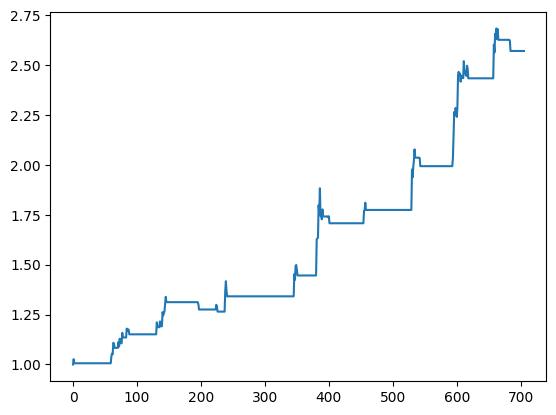

In [21]:
#Simulate trading strategies
net_profits = []
std_devs = []
def rsi_strategy(rsi_period, rsi_overbought, rsi_oversold, df, net_profits, std_devs):
    rsi_overbought = int(rsi_overbought)
    rsi_period = int(rsi_period)
    rsi_oversold = int(rsi_oversold)
    df['RSI'] = momentum.rsi(df['close'],rsi_period)
    df['rsi_signal'] = 1*(df['RSI'] > rsi_oversold)- 1*(df['RSI'] < rsi_overbought)
    start = rsi_period
    RSI_return = np.array(df['returns'][start+1:])*np.array(df['rsi_signal'][start+1:]) - fee*abs(np.array(df['rsi_signal'][start+1:]) - np.array(df['rsi_signal'][start:-1]))
    RSI = np.prod(1+RSI_return)**(252/len(RSI_return)) - 1
    RSI_risk = np.std(RSI_return)*252*0.5
    net_profits.append(RSI)
    std_devs.append(RSI_risk)

    #Visualise result
    #print('rsi return and risk: '+str(round(RSI*100,2))+ '% and '+str(round(RSI_risk*100,2)) + '%')
    plt.plot(np.append(1,np.cumprod(1+RSI_return)))

    return RSI, RSI_risk
net_profit, risk = rsi_strategy(14, 70, 30, df, net_profits, std_devs)
print(net_profits, std_devs)

buy-and-hold strategy return and risk: -5.59% and 51.21%
MACD strategy return and risk: -72.83% and 57.11%


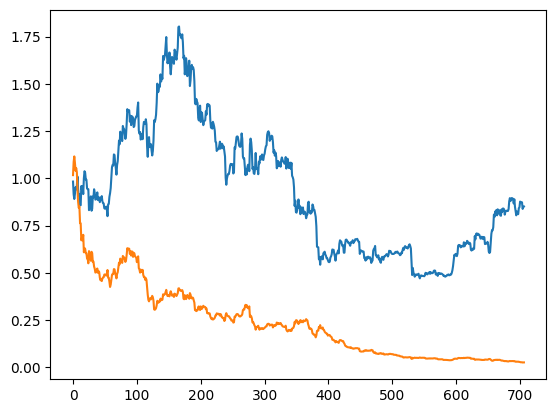

In [6]:
#simulating trading strategies
start = long_ma
df['macd_signal'] = (2*(df['MA'+str(short_ma)]>df['MA'+str(long_ma)]) - 1)
BnH_return = np.array(df['returns'][start+1:])
MACD_return = np.array(df['returns'][start+1:])*np.array(df['macd_signal'][start:-1]) - fee*abs(np.array(df['macd_signal'][start+1:]) - np.array(df['macd_signal'][start:-1]))
BnH = np.prod(1+BnH_return)**(252/len(BnH_return)) - 1
MACD = np.prod(1+MACD_return)**(252/len(MACD_return)) - 1
BnH_risk = np.std(BnH_return)*(252)**(1/2)
MACD_risk = np.std(MACD_return)*(252)**(1/2)

#visualising the results
print('buy-and-hold strategy return and risk: '+str(round(BnH*100,2))+'% and '+str(round(BnH_risk*100,2))+'%')
print('MACD strategy return and risk: '+str(round(MACD*100,2))+'% and '+str(round(MACD_risk*100,2))+'%')
plt.plot(np.cumprod(1+BnH_return))
plt.plot(np.cumprod(1+MACD_return))

buy-and-hold strategy return and risk: -13.19% and 52.73%
support and resistance strategy return and risk: -86.92% and 49.79%


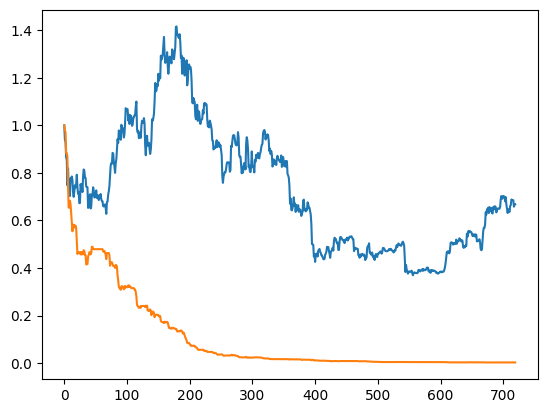

In [7]:
df['sr_signal'] = 1*(df['S&R'] < sr_buy) - 1*(df['S&R'] > sr_sell)
BnH_return = np.array(df['returns'][1:])
SR_return = np.array(df['returns'][1:])*np.array(df['sr_signal'][:-1]) - fee*abs(np.array(df['sr_signal'][1:])-np.array(df['sr_signal'][:-1]))
BnH = np.prod(1+BnH_return)**(252/len(BnH_return)) - 1
SR = np.prod(1+SR_return)**(252/len(SR_return)) - 1
BnH_risk = np.std(BnH_return)*(252)**(1/2)
SR_risk = np.std(SR_return)*(252)**(1/2)

#visualising the results
print('buy-and-hold strategy return and risk: '+str(round(BnH*100,2))+'% and '+str(round(BnH_risk*100,2))+'%')
print('support and resistance strategy return and risk: '+str(round(SR*100,2))+'% and '+str(round(SR_risk*100,2))+'%')
plt.plot(np.append(1,np.cumprod(1+BnH_return)))
plt.plot(np.append(1,np.cumprod(1+SR_return)))

buy-and-hold strategy return and risk: -13.19% and 52.73%
rsi_macd return and risk: -35.63% and 21.0%


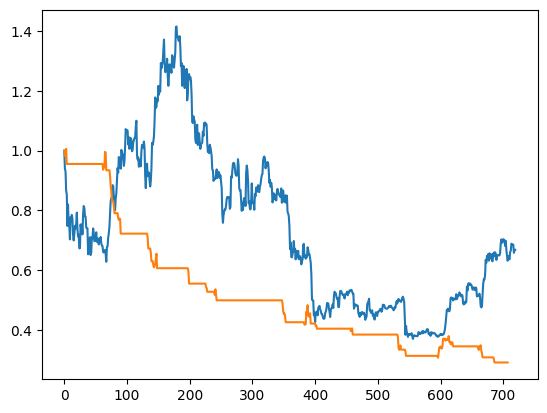

In [8]:
df['rsi_and_macd_signal'] = [1 if a == 1 and b == 1 else -1 if a == -1 and b == -1 else 0 for a, b in zip(df['rsi_signal'], df['macd_signal'])]
rsi_macd_return = np.array(df['returns'][start+1:])*np.array(df['rsi_and_macd_signal'][start:-1]) - fee*abs(np.array(df['rsi_and_macd_signal'][start+1:]) - np.array(df['rsi_and_macd_signal'][start:-1]))
rsi_macd_risk = np.std(rsi_macd_return)*252**0.5
rsi_macd = np.prod(1+rsi_macd_return)**(252/len(rsi_macd_return)) - 1
#visualising the results
print('buy-and-hold strategy return and risk: '+str(round(BnH*100,2))+'% and '+str(round(BnH_risk*100,2))+'%')
print('rsi_macd return and risk: '+str(round(rsi_macd*100,2))+'% and '+str(round(rsi_macd_risk*100,2))+'%')
plt.plot(np.append(1,np.cumprod(1+BnH_return)))
plt.plot(np.append(1,np.cumprod(1+rsi_macd_return)))

Generation:  0
Generation:  1
Generation:  2
Generation:  3
Generation:  4
Generation:  5
Generation:  6
Generation:  7
Generation:  8
Generation:  9
Generation:  10
Generation:  11
Generation:  12
Generation:  13
Generation:  14
Generation:  15
Generation:  16
Generation:  17
Generation:  18
Generation:  19
Generation:  20
Generation:  21
Generation:  22
Generation:  23
Generation:  24
Generation:  25
Generation:  26
Generation:  27
Generation:  28
Generation:  29
Generation:  30
Generation:  31
Generation:  32
Generation:  33
Generation:  34
Generation:  35
Generation:  36
Generation:  37
Generation:  38
Generation:  39
Generation:  40
Generation:  41
Generation:  42
Generation:  43
Generation:  44
Generation:  45
Generation:  46
Generation:  47
Generation:  48
Generation:  49
Generation:  50
Generation:  51
Generation:  52
Generation:  53
Generation:  54
Generation:  55
Generation:  56
Generation:  57
Generation:  58
Generation:  59
Generation:  60
Generation:  61
Generation:  62
Ge

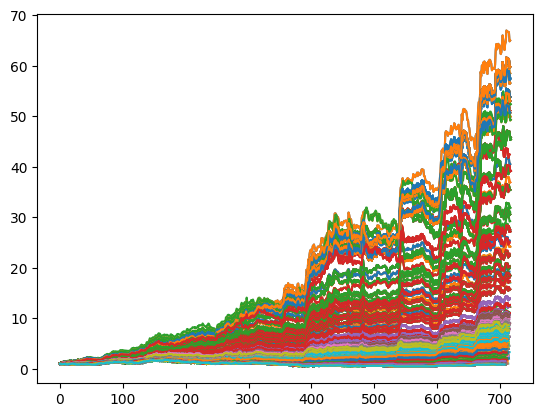

In [14]:
# Set up the genetic algorithm
population_size = 100
generations = 1000
crossover_probability = 0.8
mutation_probability = 0.2

net_profits = []
std_devs = []

# Define the fitness function
def fitness_function(hyperparameters):
    # Unpack the hyperparameters
    rsi_period, rsi_overbought, rsi_oversold = hyperparameters

    # Insert the trading algorithm here and replace the current hyperparameters with the unpacked ones
    # Calculate the return and risk
    
    net_profit, std_dev = rsi_strategy(rsi_period, rsi_overbought, rsi_oversold, df, net_profits=net_profits, std_devs=std_devs)

    # Calculate sharpe ratio
    sharpe_ratio = net_profit/std_dev

    # You can use the average net return, Sharpe ratio, or any other performance metric as the fitness
    fitness = np.mean(sharpe_ratio)

    return fitness,

# Create types
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Initialize the required components for the genetic algorithm
toolbox = base.Toolbox()
toolbox.register("attr_rsi_period", random.randint, 3, 30)
toolbox.register("attr_rsi_overbought", random.randint, 3, 30)
toolbox.register("attr_rsi_oversold", random.randint, 3, 30)
toolbox.register("attr_entry", random.uniform, 0.01, 0.1)
toolbox.register("attr_stop_loss", random.uniform, -0.2, -0.01)

toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_rsi_period,toolbox.attr_rsi_overbought, toolbox.attr_rsi_oversold), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1)
toolbox.register("select", tools.selBest)
toolbox.register("evaluate", fitness_function)

# Create the initial population
population = toolbox.population(n=population_size)

# Evaluate the fitness of each individual in the population
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

# Begin the evolution
for gen in range(generations):
    print('Generation: ', gen)
    # Select the next generation
    offspring = toolbox.select(population, len(population))
    offspring = list(offspring)

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < crossover_probability:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < mutation_probability:
                toolbox.mutate(mutant)
                del mutant.fitness.values

    # Evaluate the fitness of each individual in the new generation
    fitnesses = list(map(toolbox.evaluate, offspring))
    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = fit

    # Replace the old population by the offspring
    population[:] = offspring

# Get the best individual from the final population
best_ind = tools.selBest(population, 1)[0] 
print("Best individual is %s with fitness: %s" % (best_ind, best_ind.fitness.values))
